In [1]:
import mne
import numpy as np
import matplotlib.pyplot as plt
from mne.decoding import CSP
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline

subject_list = ["P01","P04","P05","P06","P07","P11","P12","P13","P14"]
subject_epoch = []

for subject in subject_list:
    epoch = mne.read_epochs("epoch/" + subject + "-epo.fif")
    epoch = epoch.pick("eeg")
    subject_epoch.append(epoch)

epochs = mne.epochs.concatenate_epochs(subject_epoch)

Reading c:\Users\Julian\Documents\Jupyter\Python_MNE\epoch\P01-epo.fif ...
    Read a total of 1 projection items:
        Average EEG reference (1 x 64)  idle
    Found the data of interest:
        t =    -199.22 ...    4800.78 ms
        0 CTF compensation matrices available
Not setting metadata
60 matching events found
No baseline correction applied
1 projection items activated
Removing projector <Projection | Average EEG reference, active : True, n_channels : 64>
Reading c:\Users\Julian\Documents\Jupyter\Python_MNE\epoch\P04-epo.fif ...
    Read a total of 1 projection items:
        Average EEG reference (1 x 64)  idle
    Found the data of interest:
        t =    -199.22 ...    4800.78 ms
        0 CTF compensation matrices available
Not setting metadata
60 matching events found
No baseline correction applied
1 projection items activated
Removing projector <Projection | Average EEG reference, active : True, n_channels : 64>
Reading c:\Users\Julian\Documents\Jupyter\Python_MNE\e

Computing rank from data with rank=None
    Using tolerance 0.00021 (2.2e-16 eps * 64 dim * 1.5e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0002 (2.2e-16 eps * 64 dim * 1.4e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00025 (2.2e-16 eps * 64 dim * 1.7e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00021 (2.2e-16 eps * 64 dim * 1.4e+10  max singular value)
 

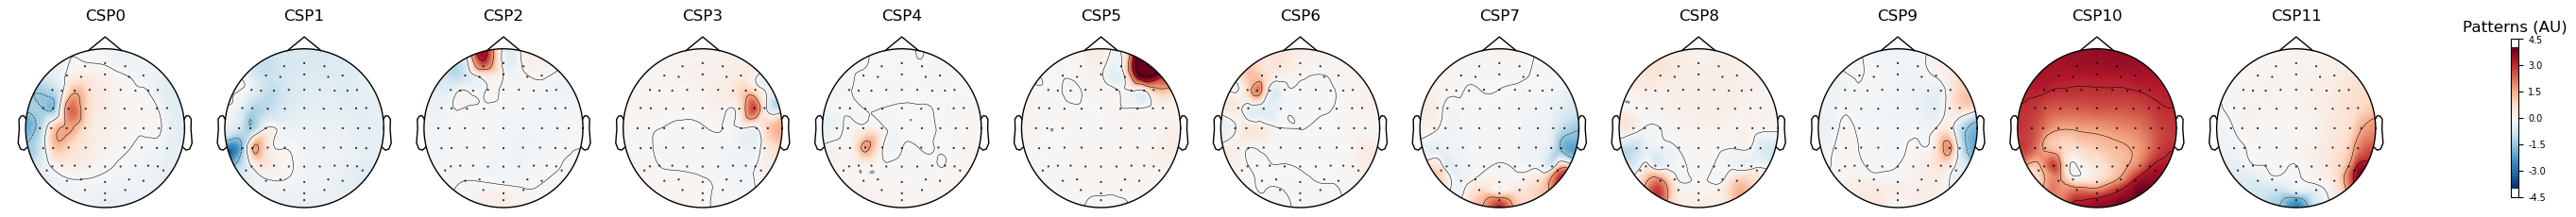

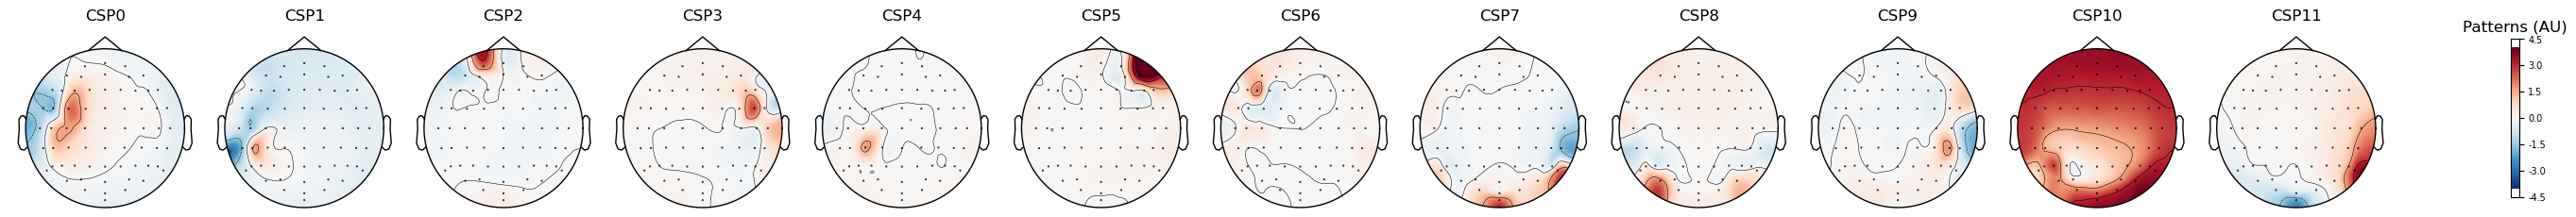

In [2]:
scores = []
labels = epochs.events[:, -1]

epochs_train = epochs.get_data(copy=False)

k = KFold(n_splits=10, random_state=42, shuffle=True)

# Assemble a classifier
lda = LinearDiscriminantAnalysis()
svm = SVC()
csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)

# Use scikit-learn Pipelin
clfLDA = Pipeline([("CSP", csp), ("LDA", lda)])
clfSVC = Pipeline([("CSP", csp), ("SVC", svm)])

# plot CSP patterns estimated on full data for visualization
csp.fit_transform(epochs_train, labels)

csp.plot_patterns(epochs.info, ch_type="eeg", units="Patterns (AU)", size=1.5)

Computing rank from data with rank=None
    Using tolerance 0.0002 (2.2e-16 eps * 64 dim * 1.4e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00019 (2.2e-16 eps * 64 dim * 1.3e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00025 (2.2e-16 eps * 64 dim * 1.7e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0002 (2.2e-16 eps * 64 dim * 1.4e+10  max singular value)
  

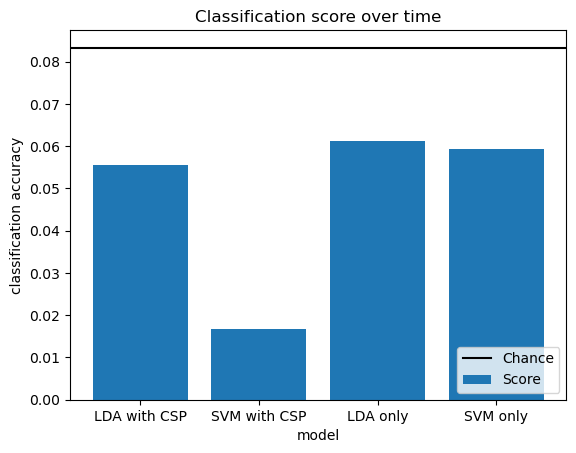

In [3]:
scores_LDACSP = []
scores_SVMCSP = []
scores_LDA = []
scores_SVM = []

for i, (train_idx, test_idx) in enumerate(k.split(epochs_train)):
    y_train, y_test = labels[train_idx], labels[test_idx]

    X_train = csp.fit_transform(epochs_train[train_idx], y_train)
    X_test = csp.transform(epochs_train[test_idx])

    lda.fit(X_train, y_train)
    svm.fit(X_train, y_train)

    X_test = csp.transform(epochs_train[test_idx])
    scores_LDACSP.append(lda.score(X_test, y_test))
    scores_SVMCSP.append(svm.score(X_test, y_test))

for i, (train_idx, test_idx) in enumerate(k.split(epochs_train)):
    y_train, y_test = labels[train_idx], labels[test_idx]

    lda.fit(X_train, y_train)
    svm.fit(X_train, y_train)

    scores_LDA.append(lda.score(X_test, y_test))
    scores_SVM.append(svm.score(X_test, y_test))

scores_LDACSP = np.array(scores_LDACSP)
scores_SVMCSP = np.array(scores_SVMCSP)
scores_LDA = np.array(scores_LDA)
scores_SVM = np.array(scores_SVM)

x_bar = ["LDA with CSP", "SVM with CSP", "LDA only", "SVM only"]
y_bar = [scores_LDACSP.mean(), scores_SVMCSP.mean(), scores_LDA.mean(), scores_SVM.mean()]

plt.figure()
plt.bar(x_bar, y_bar, label="Score")
plt.axhline(0.0833, linestyle="-", color="k", label="Chance")
plt.xlabel("model")
plt.ylabel("classification accuracy")
plt.title("Classification score over KFold = 10")
plt.legend(loc="lower right")
plt.show()